# This notebook shows how to calculate the mean AUC on the features from the final layer. The pretrained ACS and random ACS examples are presented. Other models are alike.

In [22]:
import _init_paths
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from unet import UNet as oriUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter
from poc_dataset import BaseDatasetVoxel
from mylib.utils import plot_multi_shapes, plot_multi_voxels

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


In [12]:
from poc_config import POCVoxelConfig as cfg
from poc_config import POCVoxelEnv as env

In [4]:
class UNet(oriUNet):
    def __init__(self, num_classes):
        super().__init__(num_classes)

    def get_feature(self, x):
        x = self.enc1(x)
        x1 = x.clone()
        x = self.enc2(x)
        x = self.dec1(torch.cat([x1, F.interpolate(x, scale_factor=2)], 1))
        return x

In [13]:

train_data = env.data_train
test_data = env.data_test
shape_cp = env.shape_checkpoint

train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
valid_set = None
test_set = BaseDatasetVoxel(test_data, 200)


train_loader = DataLoader(train_set, batch_size=cfg.train_batch_size, shuffle=True,
                            pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
test_loader = DataLoader(test_set, batch_size=cfg.test_batch_size, shuffle=False,
                            pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)


In [14]:
all_features = []
gts = []
model = UNet(6)
model = ACSConverter(model)
shape_cp = torch.load(shape_cp)
shape_cp.popitem()
shape_cp.popitem()
incompatible_keys = model.load_state_dict(shape_cp, strict=False)
print('load shape pretrained weights\n', incompatible_keys)
model.cuda()
model.eval()

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.cuda()
        features = F.interpolate(model.get_feature(x), scale_factor=2, mode='trilinear')
#         random_features = model_random.get_feature(x)
        all_features.append(features.cpu())
#         all_random_features.append(random_features.cpu())
        del x, features#, random_features
        gts.append(y)


  0%|          | 0/10 [00:00<?, ?it/s]

load shape pretrained weights
 _IncompatibleKeys(missing_keys=['final.weight', 'final.bias'], unexpected_keys=[])


/home/hxy/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))

100%|██████████| 10/10 [00:06<00:00,  1.92it/s]

In [15]:
all_features = torch.cat(all_features)

In [16]:
all_features.shape

torch.Size([200, 32, 48, 48, 48])

In [17]:
gts = torch.cat(gts)

In [18]:
gts = gts[:,:-1].sum(1)

In [19]:
gts.shape

torch.Size([200, 48, 48, 48])

In [23]:
pretrained_auc = np.zeros(32)
for i in range(32):
    pretrained_auc[i] = roc_auc_score(gts.flatten(), all_features[:,i].flatten())
    print(i, pretrained_auc[i])
print(pretrained_auc.mean())

0 0.5403825475651183
1 0.1285811038302523
2 0.7774155076871507
3 0.9532965642078928
4 0.9406143030116719
5 0.8537926228660593
6 0.1840238044091505
7 0.9724706645354475
8 0.9452185636611776
9 0.14924687185902605
10 0.045249287471890255
11 0.8605091591883531
12 0.03457575954091149
13 0.9500586527417155
14 0.9138537897772643
15 0.07844444744991355
16 0.047762273782486236
17 0.9855520298148932
18 0.10664903688736317
19 0.786775742808291
20 0.9704054550941865
21 0.24990163005356864
22 0.7684907248333583
23 0.9508337837017716
24 0.7480518110381925
25 0.6239492561432597
26 0.9293165602636778
27 0.9657178439768481
28 0.9260579480464312
29 0.9868196758165062
30 0.09795655645225952
31 0.9285995335004847
0.6375179222505178


# AUC of random ACS 

In [34]:
all_random_features = []
gts = []
model_random = UNet(6)
model_random = ACSConverter(model_random)
model_random.cuda()
model_random.eval()
with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.cuda()
#         features = F.interpolate(model.get_feature(x), scale_factor=2, mode='trilinear')
        random_features = F.interpolate(model_random.get_feature(x), scale_factor=2, mode='trilinear')
#         all_features.append(features.cpu())
        all_random_features.append(random_features.cpu())
        del x, random_features#, random_features
        gts.append(y)


  0%|          | 0/10 [00:00<?, ?it/s]/home/hxy/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

In [35]:
all_random_features = torch.cat(all_random_features)

In [36]:
all_random_features.shape

torch.Size([200, 32, 48, 48, 48])

In [40]:
gts = torch.cat(gts)

In [41]:
gts = gts[:,:-1].sum(1)

In [42]:
gts.shape

torch.Size([200, 48, 48, 48])

In [43]:
random_auc = np.zeros(32)
for i in range(32):
    random_auc[i] = roc_auc_score(gts.flatten(), all_random_features[:,i].flatten())
    print(i, random_auc[i])
print(random_auc.mean())

0 0.12779435424731492
1 0.7405222960281823
2 0.9621561098148652
3 0.8597092005306003
4 0.9715571771707239
5 0.45470094912905445
6 0.12078017754523629
7 0.9834419200252179
8 0.7180263446420385
9 0.4920825008928109
10 0.5137663942580295
11 0.5
12 0.5084743238434396
13 0.24642037256899282
14 0.4605021639084199
15 0.9605542469310315
16 0.5128062201767885
17 0.49568599826194637
18 0.5993036462237372
19 0.5000125773477443
20 0.8525683099644852
21 0.9271359466527214
22 0.844142721293847
23 0.21938087994973143
24 0.797958647061781
25 0.8824684869152049
26 0.49749708426297345
27 0.974609424158798
28 0.8037984239910225
29 0.49064633101417293
30 0.5
31 0.7282205513364588
0.6327101181296053


# Visualization

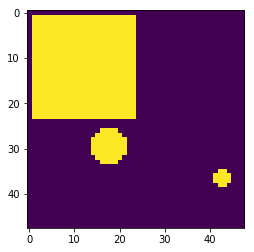

In [28]:
plt.imshow(gts[0,30])

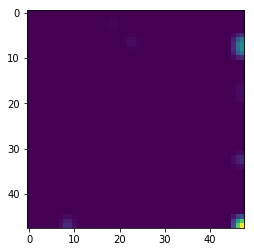

In [48]:
plt.imshow(all_random_features[0, 29 ,30])

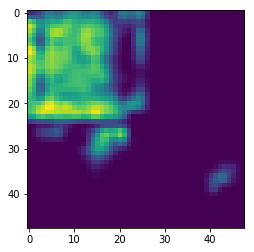

In [53]:
plt.imshow(all_features[0, 29 ,30])

# mean AUC of pretrained ACS and random ACS

In [24]:
np.maximum(pretrained_auc, 1-pretrained_auc).mean()

0.8798684990169666

In [44]:
# This value could vary due to different randomlization seeds.
np.maximum(random_auc, 1-random_auc).mean()

0.7198669423933144